In [2]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import os

2025-10-07 15:54:39.895638: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759852480.058835      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759852480.110303      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
DATA_PATH = '/kaggle/input/100-kanji-etl8g'

In [3]:
num_classes = len([name for name in os.listdir(DATA_PATH)])

In [4]:
IMG_SHAPE = (128, 128)

# Bước 1. Load dữ liệu
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SHAPE,
    batch_size=64,
    color_mode='grayscale'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SHAPE,
    batch_size=64,
    color_mode='grayscale'
)

Found 15728 files belonging to 100 classes.
Using 12583 files for training.


I0000 00:00:1759839410.908091      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 15728 files belonging to 100 classes.
Using 3145 files for validation.


In [5]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.05),
    tf.keras.layers.RandomTranslation(0.05, 0.05),
    tf.keras.layers.RandomContrast(0.1),
])


In [6]:
# Bước 3. Chuẩn hóa
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Bước 4. Gộp pipeline
train_ds = (
    train_ds
    .map(lambda x, y: (data_augmentation(x, training=True), y))  # áp dụng augmentation
    .map(lambda x, y: (normalization_layer(x), y))               # rồi chuẩn hóa
    .cache()
    .shuffle(1000)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

val_ds = (
    val_ds
    .map(lambda x, y: (normalization_layer(x), y))
    .cache()
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


In [7]:
from tensorflow.keras import layers, models

def build_kanji_cnn(num_classes, input_shape=(128, 128, 1)):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        # --- Block 1 ---
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # --- Block 2 ---
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # --- Block 3 ---
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # --- Block 4 ---
        layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # --- Head ---
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Ví dụ khởi tạo:

model = build_kanji_cnn(num_classes)

# Kiểm tra cấu trúc
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             

 Total params: 5,793,316 (22.10 MB)

 Trainable params: 5,789,476 (22.09 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [8]:
from tensorflow.keras import callbacks, optimizers
import tensorflow as tf

def train_model(
    model,
    train_ds,
    val_ds,
    epochs=30,
    learning_rate=1e-4,
    model_save_path='best_model.h5',
    patience=5,
    reduce_lr_patience=3
):

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name='sparse_categorical_accuracy'),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top5_acc')
        ]
    )


    monitor_metric = 'val_sparse_categorical_accuracy'

    # Callbacks
    cb_list = [
        callbacks.ModelCheckpoint(
            model_save_path,
            monitor=monitor_metric,
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        callbacks.EarlyStopping(
            monitor=monitor_metric,
            patience=patience,
            restore_best_weights=True,
            mode='max',
            verbose=1
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.3,
            patience=reduce_lr_patience,
            verbose=1,
            min_lr=1e-6
        )
    ]

    # Train
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=cb_list,
        verbose=1
    )

    print("\n✅ Huấn luyện hoàn tất. Mô hình tốt nhất được lưu tại:", model_save_path)
    return history


In [9]:
history = train_model(
    model,
    train_ds,
    val_ds,
    epochs=20,
    learning_rate=3e-3,
    model_save_path='kanji_800_best.h5',
    patience=6,
    reduce_lr_patience=2
)


Epoch 1/20


I0000 00:00:1759839453.752710     101 service.cc:148] XLA service 0x7901ac007830 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759839453.753557     101 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1759839454.718277     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/197 ━━━━━━━━━━━━━━━━━━━━ 3:02:17 56s/step - loss: 5.0481 - sparse_categorical_accuracy: 0.0312 - top5_acc: 0.0625

I0000 00:00:1759839472.270570     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 4.2746 - sparse_categorical_accuracy: 0.0386 - top5_acc: 0.1627
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.02289, saving model to kanji_800_best.h5
197/197 ━━━━━━━━━━━━━━━━━━━━ 102s 236ms/step - loss: 4.2725 - sparse_categorical_accuracy: 0.0388 - top5_acc: 0.1631 - val_loss: 16.9267 - val_sparse_categorical_accuracy: 0.0229 - val_top5_acc: 0.0919 - learning_rate: 0.0030
Epoch 2/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 3.0282 - sparse_categorical_accuracy: 0.1441 - top5_acc: 0.4765
Epoch 2: val_sparse_categorical_accuracy improved from 0.02289 to 0.02639, saving model to kanji_800_best.h5
197/197 ━━━━━━━━━━━━━━━━━━━━ 24s 124ms/step - loss: 3.0272 - sparse_categorical_accuracy: 0.1443 - top5_acc: 0.4768 - val_loss: 23.1984 - val_sparse_categorical_accuracy: 0.0264 - val_top5_acc: 0.1259 - learning_rate: 0.0030
Epoch 3/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 2.2629 - sparse_categorical_acc

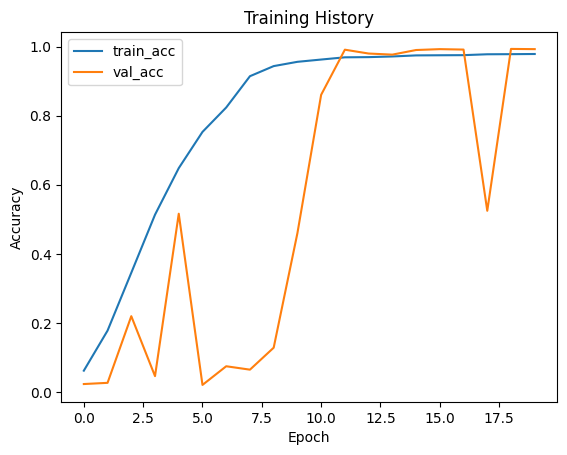

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history['sparse_categorical_accuracy'], label='train_acc')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='val_acc')
plt.legend(); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Training History');
plt.show()


In [16]:
import os
import numpy as np
import tensorflow as tf

def preprocess_image(img_path, img_size=(128, 128)):
    """Chuẩn hóa 1 ảnh grayscale để predict."""
    img = tf.keras.utils.load_img(img_path, color_mode='grayscale', target_size=img_size)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # (1, H, W, 1)
    return img_array


def predict_folder(model, folder_path, class_names, img_size=(128, 128), max_display=10):
    """
    Dự đoán tất cả ảnh trong folder và in ra kết quả.
    """
    image_files = [
        os.path.join(folder_path, f)
        for f in os.listdir(folder_path)
        if f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ]

    print(f"🔍 Tìm thấy {len(image_files)} ảnh trong thư mục '{folder_path}'")

    results = []
    for img_path in image_files:
        img_tensor = preprocess_image(img_path, img_size)
        pred = model.predict(img_tensor, verbose=0)
        pred_class = np.argmax(pred, axis=1)[0]
        pred_label = class_names[pred_class]
        results.append((img_path, pred_label))

    # In ra vài kết quả đầu
    print("\n📘 Một vài dự đoán đầu tiên:")
    for i, (path, label) in enumerate(results[:max_display]):
        print(f"{i+1:02d}. {os.path.basename(path)}  →  {label}")

    return results


In [5]:

# Lấy tất cả thư mục con trong DATA_PATH
class_names = sorted([
    d for d in os.listdir(DATA_PATH)
    if os.path.isdir(os.path.join(DATA_PATH, d))
])

print(f"Số lượng class: {len(class_names)}")
print("10 class đầu tiên:", class_names[:10])


Số lượng class: 100
10 class đầu tiên: ['一', '丁', '七', '万', '三', '上', '下', '不', '世', '両']


In [6]:
class_names

['一',
 '丁',
 '七',
 '万',
 '三',
 '上',
 '下',
 '不',
 '世',
 '両',
 '中',
 '主',
 '久',
 '乗',
 '九',
 '予',
 '争',
 '事',
 '二',
 '五',
 '交',
 '京',
 '人',
 '仁',
 '今',
 '仏',
 '仕',
 '他',
 '付',
 '代',
 '令',
 '以',
 '仮',
 '件',
 '任',
 '休',
 '会',
 '伝',
 '似',
 '位',
 '低',
 '住',
 '体',
 '何',
 '余',
 '作',
 '使',
 '例',
 '供',
 '依',
 '価',
 '便',
 '係',
 '俗',
 '保',
 '信',
 '修',
 '俵',
 '倉',
 '個',
 '倍',
 '候',
 '借',
 '停',
 '健',
 '側',
 '備',
 '働',
 '像',
 '億',
 '元',
 '兄',
 '先',
 '光',
 '児',
 '党',
 '入',
 '全',
 '八',
 '公',
 '六',
 '共',
 '兵',
 '具',
 '典',
 '兼',
 '内',
 '円',
 '再',
 '写',
 '冬',
 '冷',
 '処',
 '出',
 '刀',
 '分',
 '切',
 '刊',
 '列',
 '初']

In [18]:
from tensorflow.keras.models import load_model

# Load model
model = load_model(
    'kanji_800_best.h5',
    compile=False
)

In [19]:
test_folder = "/kaggle/input/test-etl8g/test"

results = predict_folder(model, test_folder, class_names)


🔍 Tìm thấy 10 ảnh trong thư mục '/kaggle/input/test-etl8g/test'

📘 Một vài dự đoán đầu tiên:
01. b8d678f5-ffef-4414-aa07-52fcd829dd32.jpg  →  両
02. 991878fc-61cf-4bf1-9875-d28b1cc0cc75.jpg  →  一
03. 80cef964-4e3f-4135-a979-ce76995b4f47.jpg  →  二
04. 7c68b3d7-5c1a-4c7e-9ae2-8513d47b1e9e.jpg  →  上
05. 9745ed26-9a03-4ef2-a37d-7267d56d1a12.jpg  →  万
06. 67af4f80-fb30-4fa8-b43d-b1aabf341cc5.jpg  →  下
07. cd3db83b-c479-41cb-96a7-0bb35c89da64.jpg  →  事
08. fd00db92-0246-4a61-a172-0deceacfd748.jpg  →  億
09. 6abccf05-4a7f-426c-a74a-e5bc82e7d98f.jpg  →  久
10. 4042dc21-f97c-466f-be4d-adcb8ec11ba2.jpg  →  側
